<a href="https://colab.research.google.com/github/HilbertN/Redes_Neuronales/blob/main/RN18_Conv1D_y_series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical

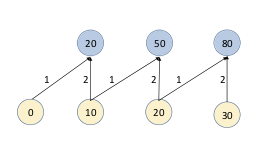

In [ ]:
model = Sequential()
model.add(Convolution1D(filters=1,
                 kernel_size=2,
                 padding='causal',
                 dilation_rate=1,
                 use_bias=False,
                 batch_input_shape=(None,3, 1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 1)              2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.set_weights([np.asarray([[[1]],[[2]]])])
print(model.get_weights())

[array([[[1.]],

       [[2.]]], dtype=float32)]


In [ ]:
x_in=np.array([10,20,30])
x_in=x_in.reshape(1,3,1)
print("input")
print(x_in)
print("output")
print(model.predict(x_in))

input
[[[10]
  [20]
  [30]]]
output
1/1 [==============================] - 0s 226ms/step
[[[20.]
  [50.]
  [80.]]]


Otro ejemplo

<ipython-input-3-2eacc583c0f6>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')


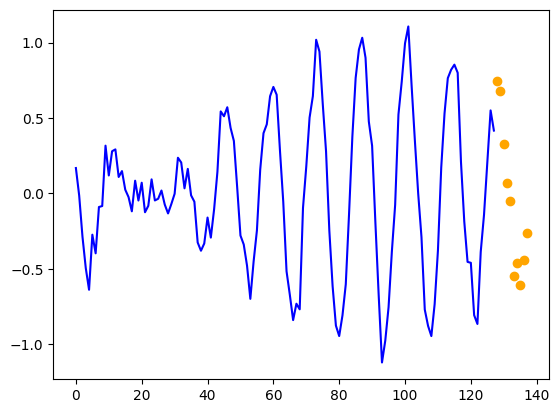

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [ ]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

In [ ]:
X.shape, Y.shape

((1000, 128, 1), (1000, 10, 1))

In [ ]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

model1 = Sequential()
ks = 5
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', batch_input_shape=(None, None, 1)))
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(Dense(1))
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model1.summary()
model1.compile(optimizer='adam', loss='mean_squared_error')


history1 = model1.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 32)          192       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          5152      
                                                                 
 dense_1 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_1 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15681 (61.25 KB)
Trainable params: 15681

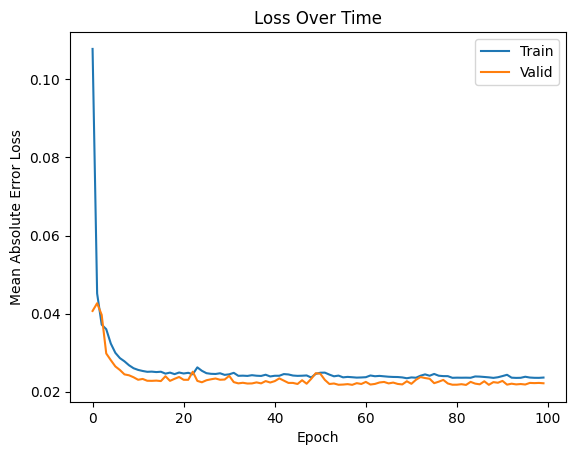

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
X,Y = gen_data(noise=0)
res = model1.predict(X)
print('Shapes X {} Y{} res{}'.format(X.shape, Y.shape, res.shape))
print('MSE for complete look-ahead ', np.average((res[:,:,0] - Y[:,:,0])**2))
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2))
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2))

32/32 [==============================] - 0s 6ms/step
Shapes X (1000, 128, 1) Y(1000, 10, 1) res(1000, 10, 1)
MSE for complete look-ahead  0.0059637200091955745
MSE for one step look-ahead  0.013382646140208662
MSE baseline (same as last) 0.06147579415035294


In [ ]:
x_test,y_test = gen_data(size=1,noise=0.0)
model1.predict(x_test).reshape(-1),y_test.reshape(-1)

1/1 [==============================] - 0s 23ms/step


(array([ 0.94125885,  0.95779735,  0.785771  ,  0.46334863,  0.05940699,
        -0.34130144, -0.6560948 , -0.8215864 , -0.8065681 , -0.6179066 ],
       dtype=float32),
 array([ 0.85230934,  0.88453287,  0.73468149,  0.43794298,  0.05913728,
        -0.32152731, -0.6255856 , -0.7926458 , -0.7924877 , -0.63048301]))

In [ ]:
def predict_sequence(input_sequence, model, pred_steps):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps * look_ahead,1)) # initialize output (pred_steps time steps)

    for i in range(pred_steps):

        # record next time step prediction (last time step of model output)
        last_step_pred = model.predict(history_sequence)[0,-look_ahead:,0]
        pred_sequence[0,(i * look_ahead) : ((i+1) * look_ahead),0] = last_step_pred

        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence,
                                           last_step_pred.reshape(-1,look_ahead,1)], axis=1)

    return pred_sequence

1/1 [==============================] - 0s 23ms/step


(-1.0, 1.0)

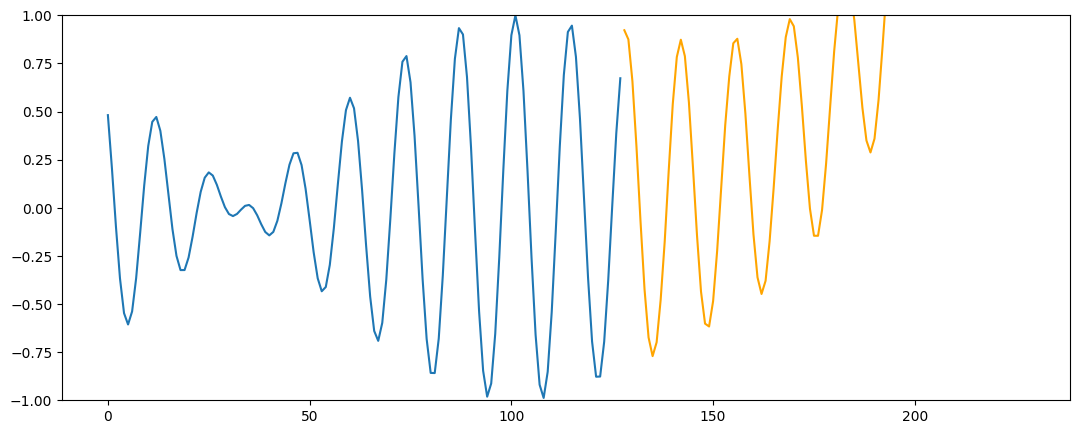

In [ ]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 10
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, model1, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
plt.ylim((-1,1))

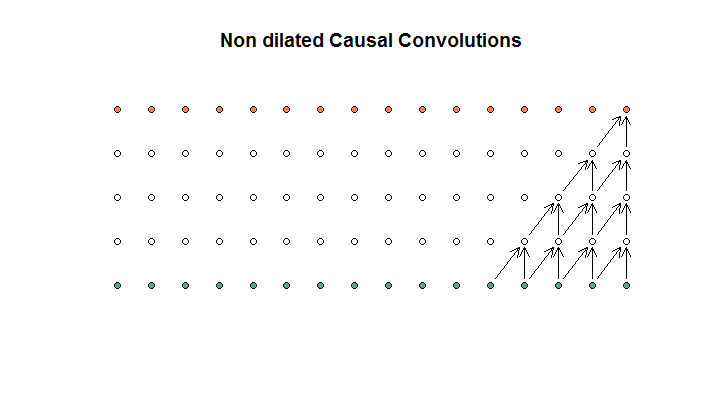

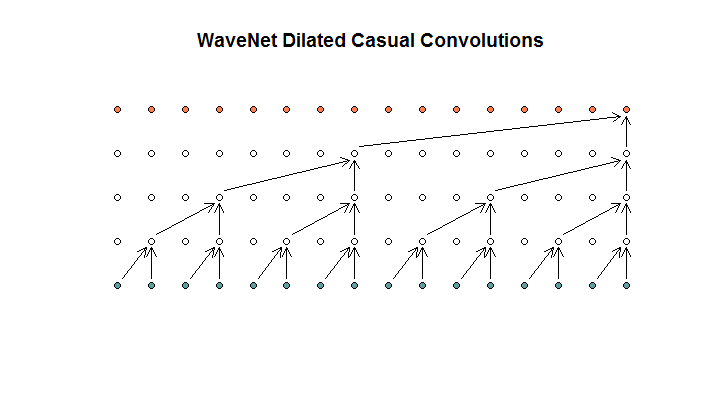

In [ ]:
X,Y = gen_data(noise=0)

modeldil = Sequential()

modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1,
                           batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()

modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(X[0:800], Y[0:800],
                    epochs=200,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]), verbose=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, None, 32)          192       
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_11 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_12 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_2 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_2 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15681 (61.25 KB)
Trainable params: 15681

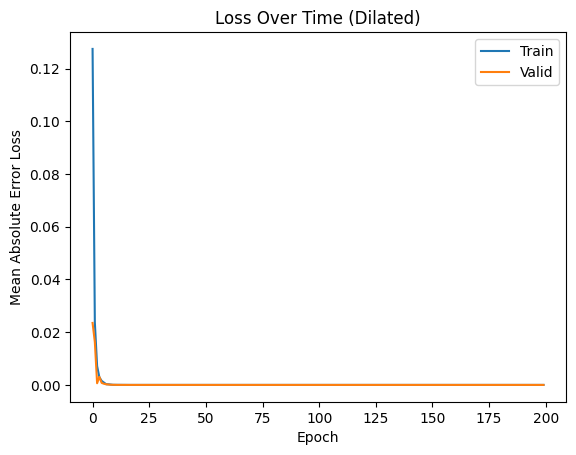

In [ ]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

In [ ]:
# Testing
X,Y = gen_data()
res = modeldil.predict(X)
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) #One step look-ahead prediction
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2))

32/32 [==============================] - 1s 8ms/step
MSE for one step look-ahead  0.012655382679313388
MSE baseline (same as last) 0.08270541455379668


1/1 [==============================] - 0s 23ms/step


(-1.0, 1.0)

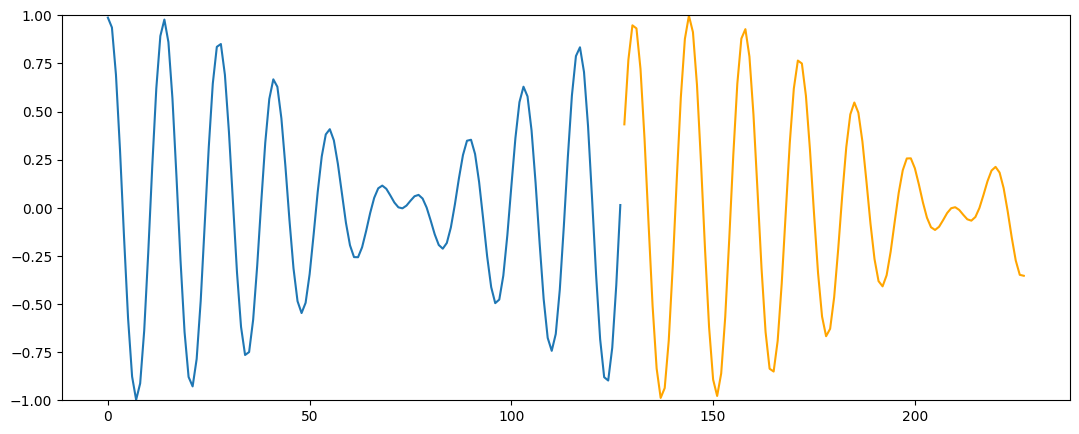

In [ ]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 10
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, modeldil, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
plt.ylim((-1,1))